# Initialization


## Dowloads

In [10]:
# Dowloads (run this cell in case is the first time using the notebook)
'''
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pickle
!{sys.executable} -m pip install os
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install imp
!{sys.executable} -m pip install importlib
'''


'\nimport sys\n!{sys.executable} -m pip install numpy\n!{sys.executable} -m pip install matplotlib\n!{sys.executable} -m pip install pickle\n!{sys.executable} -m pip install os\n!{sys.executable} -m pip install scipy\n!{sys.executable} -m pip install tqdm\n!{sys.executable} -m pip install imp\n!{sys.executable} -m pip install importlib\n'

## Imports

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.constants import c, pi
from tqdm.notebook import tqdm  
import sys
import pickle as pck
import pandas as pd
import scipy as sci
import Functions

In [3]:
# Creating lumerical integration
sys.path.append('../')
try:
    import imp
    try:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
        lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
    except:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v221\\api\\python\\')
        lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')
except:
    print('imp module not found. Trying with importlib...')
    from importlib.machinery import SourceFileLoader
    try:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
        lumapi = SourceFileLoader('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py').load_module()
    except:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v221\\api\\python\\')
        lumapi = SourceFileLoader('lumapi','C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py').load_module()

imp module not found. Trying with importlib...


C:\Program Files\Lumerical\v221\api\python\lumapi.py:796: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


## Intial Parameters

In [108]:
# General use variables 
λ0 = 1550e-9
π = pi
c0 = c

simulation_band = [1520e-9,1575e-9]
cband = [1530e-9, 1565e-9]

si = 'Si (Silicon) - Palik'
siO2 = 'SiO2 (Glass) - Palik'

# Ideal MZI with loss simulations

In [104]:
# Initializing INTERCONNECT
inter = lumapi.INTERCONNECT()

## Component initialization and test

In [121]:
component_name = 'MZI_WITH_LOSS'
loss = 0.48

inter.switchtolayout()
inter.deleteall()

# Creating cross MZI 

inter.addelement(component_name)
inter.set({'x position':0,
           'y position':300,
           'name': 'cross',
           'loss': loss,
           'Theta 1' : 0,
           'Theta 2' : 0})

# Creating Tunable Coupler 0.5/0.5 MZI

inter.addelement(component_name)
inter.set({'x position':400,
           'y position':300,
           'name': 'TC',
           'loss': loss,
           'Theta 1' : π/2,
           'Theta 2' : 0})

# Creating bar MZI

inter.addelement(component_name)
inter.set({'x position':800,
           'y position':300,
           'name': 'bar',
           'loss': loss,
           'Theta 1' : π,
           'Theta 2' : 0})

# Creating ONA for the MZIs

ports = 4
points = 1001

for i in range(3):
    addONA(inter, simulation_band[0],simulation_band[1],points,ports, i*400, 0)


# Connecting the ONAs and the MZIs

ConnectONA(inter, 'ONA_1', 'cross',[1,1,3,4,2])
ConnectONA(inter, 'ONA_2', 'TC',  [1,1,3,4,2])
ConnectONA(inter, 'ONA_3', 'bar', [1,1,3,4,2])

In [123]:
inter.run()

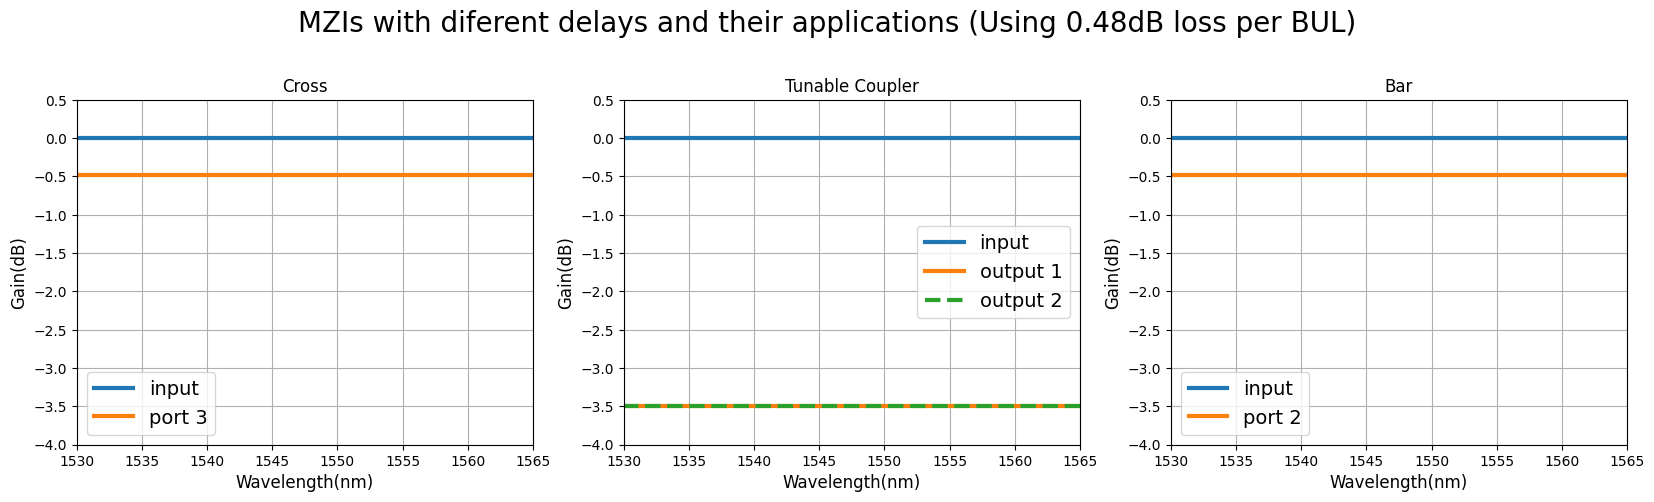

In [165]:
figure1,fig = plt.subplots(1,3,figsize=[20,5]);

gaincross = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gainTC1 = inter.getresult('ONA_2','input 2/mode 1/gain')['TE gain (dB)']
gainTC2 = inter.getresult('ONA_2','input 3/mode 1/gain')['TE gain (dB)']
gainbar = inter.getresult('ONA_3','input 2/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)
input = np.zeros(len(λ))

figure1.suptitle('MZIs with diferent delays and their applications (Using 0.48dB loss per BUL)', fontsize = 20)
figure1.subplots_adjust(top=0.8)

fig[0].set_title('Cross')
fig[0].grid()
fig[0].plot(λ, input, label= 'input', linewidth = 3)
fig[0].plot(λ, gaincross, label = 'port 3', linewidth = 3)
fig[0].legend(fontsize = 14)
fig[0].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[0].set_ylim(-4,0.5)
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Tunable Coupler')
fig[1].grid()
fig[1].plot(λ, input, label= 'input', linewidth = 3)
fig[1].plot(λ, gainTC1, label = 'output 1', linewidth = 3)
fig[1].plot(λ, gainTC1,'--', label = 'output 2', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylim(-4,0.5)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

fig[2].set_title('Bar')
fig[2].grid()
fig[2].plot(λ, input, label= 'input', linewidth = 3)
fig[2].plot(λ, gaincross, label = 'port 2', linewidth = 3)
fig[2].legend(fontsize = 14)
fig[2].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[2].set_ylim(-4,0.5)
fig[2].set_ylabel('Gain(dB)', fontsize=12)
fig[2].set_xlabel('Wavelength(nm)', fontsize=12);